# Machine Learning and Pattern Classification - The haunted turtles
~Noah Pichler, Jacob Harrer, Christopher Schicho, Martin Gegenbauer
## Data Exploration

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

cmap = sns.diverging_palette(230, 20, as_cmap=True)

import warnings
warnings.filterwarnings('ignore')

In [3]:
anot = pd.read_pickle("./data/task_2_annotations.pkl")
anot = anot.fillna(anot.median())
anot.head()

pianist_id  segment_id  annotator_id  arousal  valence  gems_wonder  \
0             1           0            91        1       -1            2   
31            1           0            19        2       -1            3   
62            1           0           189        2        0            2   
93            1           0           126        2        2            4   
124           1           0            26        4        2            3   

     gems_transcendence  gems_tenderness  gems_nostalgia  gems_peacefulness  \
0                     1                2               4                2.0   
31                    3                3               4                4.0   
62                    1                2               1                4.0   
93                    5                2               3                5.0   
124                   5                2               3                3.0   

     gems_power  gems_joyful_activation  gems_tension  gems_sadness  \
0             1                       1             1             2   
31            1                       2             3             3   
62            2                       2             1             1   
93            2                       4             1             3   
124           1                       3             4             1   

     gemmes_flow  gemmes_movement  gemmes_force  gemmes_interior  \
0              3                2             1              1.0   
31             3                2             2              3.0   
62             3                2             1              1.0   
93             5                1             2              2.0   
124            4                1             2              3.0   

     gemmes_wandering  
0                   2  
31                  3  
62                  4  
93                  5  
124                 1

In [5]:
feat = pd.read_pickle("./data/task_2_features.pkl")
feat.head()

pianist_id  segment_id  snippet_id  essentia_dissonance_mean  \
0           1           0           0                  0.192237   
1           1           0           1                  0.143425   
2           1           0           2                  0.146967   
3           1           0           3                  0.158810   
4           1           0           4                  0.168547   

   essentia_dissonance_stdev  essentia_dynamic_complexity  essentia_loudness  \
0                   0.059404                     2.040252         16079768.0   
1                   0.064204                     3.138845         35489248.0   
2                   0.056205                     2.019706         42130144.0   
3                   0.059129                     3.567908         40922732.0   
4                   0.049648                     2.329854         51921612.0   

   essentia_onset_rate  essentia_pitch_salience_mean  \
0                  0.8                      0.677256   
1                  2.6                      0.514913   
2                  2.6                      0.560116   
3                  1.4                      0.596779   
4                  1.6                      0.556160   

   essentia_pitch_salience_stdev  ...  mirtoolbox_novelty_std  \
0                       0.095846  ...                0.106446   
1                       0.092372  ...                0.193342   
2                       0.115359  ...                0.218179   
3                       0.116061  ...                0.118148   
4                       0.143420  ...                0.121018   

   mirtoolbox_novelty_pct_10  mirtoolbox_novelty_pct_50  \
0                    0.00000                   0.013819   
1                    0.00000                   0.027786   
2                    0.00000                   0.049050   
3                    0.00002                   0.017653   
4                    0.00000                   0.020525   

   mirtoolbox_novelty_pct_90  mirtoolbox_pulseclarity  \
0                   0.082176                 0.169743   
1                   0.356029                 0.355861   
2                   0.375251                 0.209162   
3                   0.098657                 0.232454   
4                   0.157408                 0.140930   

   mirtoolbox_roughness_mean  mirtoolbox_roughness_std  \
0                   0.011449                  0.004161   
1                   0.006205                  0.003194   
2                   0.007467                  0.003986   
3                   0.007335                  0.004063   
4                   0.007345                  0.003917   

   mirtoolbox_roughness_pct_10  mirtoolbox_roughness_pct_50  \
0                     0.006684                     0.011048   
1                     0.002583                     0.005657   
2                     0.002330                     0.007206   
3                     0.002609                     0.006807   
4                     0.002662                     0.007016   

   mirtoolbox_roughness_pct_90  
0                     0.017025  
1                     0.010610  
2                     0.012690  
3                     0.012971  
4                     0.012731  

[5 rows x 172 columns]

In [64]:
def filter_by_pianist_and_segment(df: pd.DataFrame, pianist_id: int, segment_id: int) -> pd.DataFrame:
    df = df.copy()
    df = df[df["pianist_id"] == pianist_id]
    return df[df["segment_id"] == segment_id]

def get_label(arousal: int, valance: int) -> str:
    # changed 3 -> 0 because of normalization
    if valance > 0 and arousal >= 0:
        return "Happy"
    elif valance <= 0 and arousal > 0:
        return "Angry"
    elif valance < 0 and arousal <= 0:
        return "Sad"
    elif valance >= 0 and arousal < 0:
        return "Relaxed"
    else:
        return "Unknown"

def aggregate_discrete_label(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    labels = []
    column_names = list(df.columns)
    pianist_col_idx = column_names.index("pianist_id")
    segment_col_idx = column_names.index("segment_id")

    for sample in df.values:
        filtered_df = filter_by_pianist_and_segment(df, sample[pianist_col_idx], sample[segment_col_idx])
        arousal_agg = filtered_df["arousal"].median()
        valance_agg = filtered_df["valence"].median()
        labels.append(get_label(arousal_agg, valance_agg))

    df["label"] = labels
    return df

def normalize(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    anota = df.annotator_id.unique()
    cols_to_norm = df.columns.difference(["pianist_id", "segment_id", "annotator_id"])
    
    for a_id in anota:
        sub_df = df[df.annotator_id == a_id]
        sub_df[cols_to_norm] = (sub_df[cols_to_norm] - sub_df[cols_to_norm].mean()) / sub_df[cols_to_norm].std()
        df[df.annotator_id == a_id] = sub_df
        
    return df

anot_n = normalize(anot)
anot = aggregate_discrete_label(anot_n)
anot.head()

pianist_id  segment_id  annotator_id   arousal   valence  gems_wonder  \
0             1           0            91 -1.933003 -0.779610     0.122380   
31            1           0            19 -1.179377 -0.901388    -0.531610   
62            1           0           189 -0.503236 -0.354235    -0.346144   
93            1           0           126 -1.140175  1.168566     1.351324   
124           1           0            26  0.563918  1.461206     0.203906   

     gems_transcendence  gems_tenderness  gems_nostalgia  gems_peacefulness  \
0             -0.566947    -4.788287e-02        1.598264           0.047883   
31            -0.880271     1.390872e-01        0.457905           1.502731   
62            -0.884282    -9.449112e-02       -0.834523           1.271936   
93             2.234648    -8.618916e-02        0.781602           2.121320   
124            1.316561     7.930164e-18        0.849837          -0.240074   

     gems_power  gems_joyful_activation  gems_tension  gems_sadness  \
0     -0.562236               -0.746937     -1.209073      0.279576   
31    -1.353404               -0.769534     -0.203906      0.538682   
62    -0.203906               -0.312641     -0.887114     -0.346144   
93     0.000000                1.285422     -0.551807      1.770291   
124   -1.203942                1.012757      1.031327     -0.566947   

     gemmes_flow  gemmes_movement  gemmes_force  gemmes_interior  \
0       0.481070        -0.408248     -0.663212        -0.763581   
31     -0.457905        -0.969628     -0.806226         0.150493   
62     -0.206623        -1.021857     -0.963624        -0.931133   
93      1.316561        -0.609449     -0.240074        -0.043577   
124     0.938912        -0.999829     -0.524531         0.524531   

     gemmes_wandering label  
0            0.755929   Sad  
31           1.483596   Sad  
62           0.901388   Sad  
93           1.437735   Sad  
124         -0.692150   Sad

In [65]:
anot["label"].unique()

array(['Sad', 'Happy', 'Angry', 'Relaxed'], dtype=object)

In [66]:
#distribution
n_samples = len(anot.values)
distribution = dict()
for label in list(anot["label"].unique()):
    distribution[label] = len(anot[anot["label"] == label].values) / n_samples

distribution

{'Sad': 0.21152388172858225,
 'Happy': 0.1899166034874905,
 'Angry': 0.3100833965125095,
 'Relaxed': 0.2884761182714177}

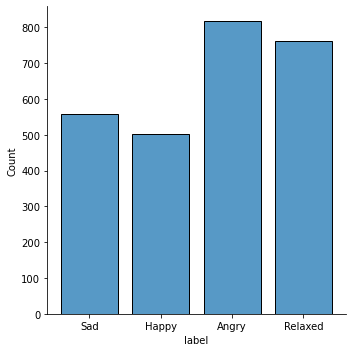

In [63]:
sns.displot(data=anot, x="label", shrink=.8)

In [68]:
#plt.figure(figsize=(20,20))
#sns.swarmplot(data=anot, x="valence", y="arousal", hue="label")

In [69]:
feature_cols = list(anot.columns)[3:][:-1]
all_feature_df = anot.loc[:, feature_cols]

<AxesSubplot:title={'center':'Distribution of features over all samples'}>

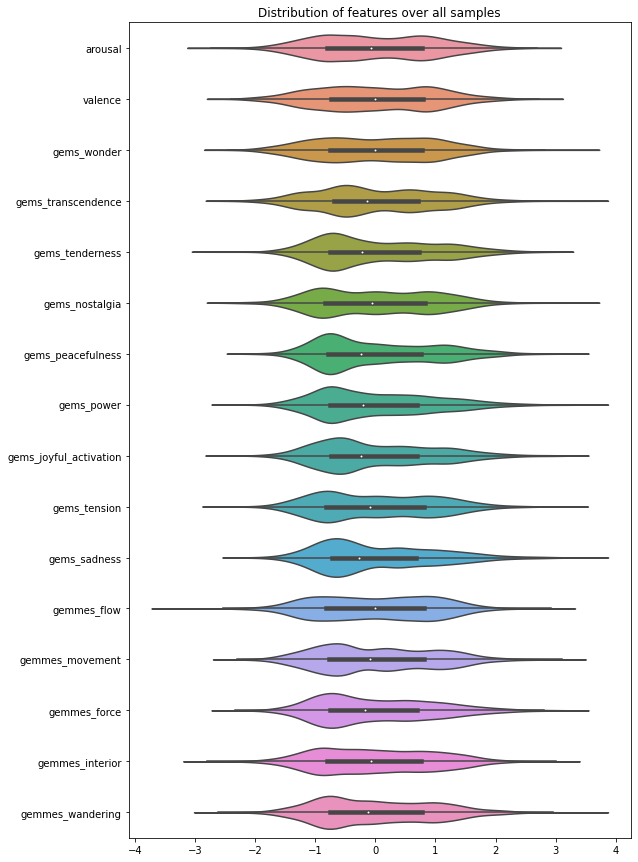

In [70]:
plt.figure(figsize=(9,15))
plt.title("Distribution of features over all samples")
sns.violinplot(data=all_feature_df, orient='h')

<AxesSubplot:title={'center':'Correlations over all samples'}>

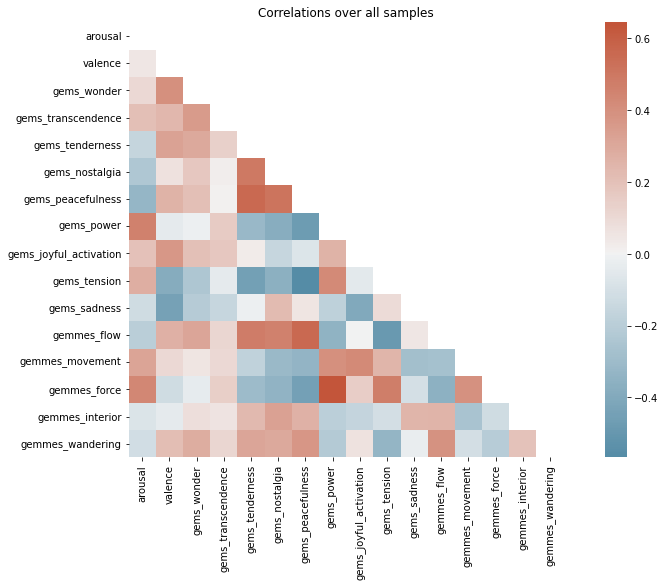

In [71]:
corr_df = all_feature_df.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
plt.figure(figsize=(15,8))
plt.title("Correlations over all samples")
sns.heatmap(corr_df, mask=mask, cmap=cmap, square=True, center=0)

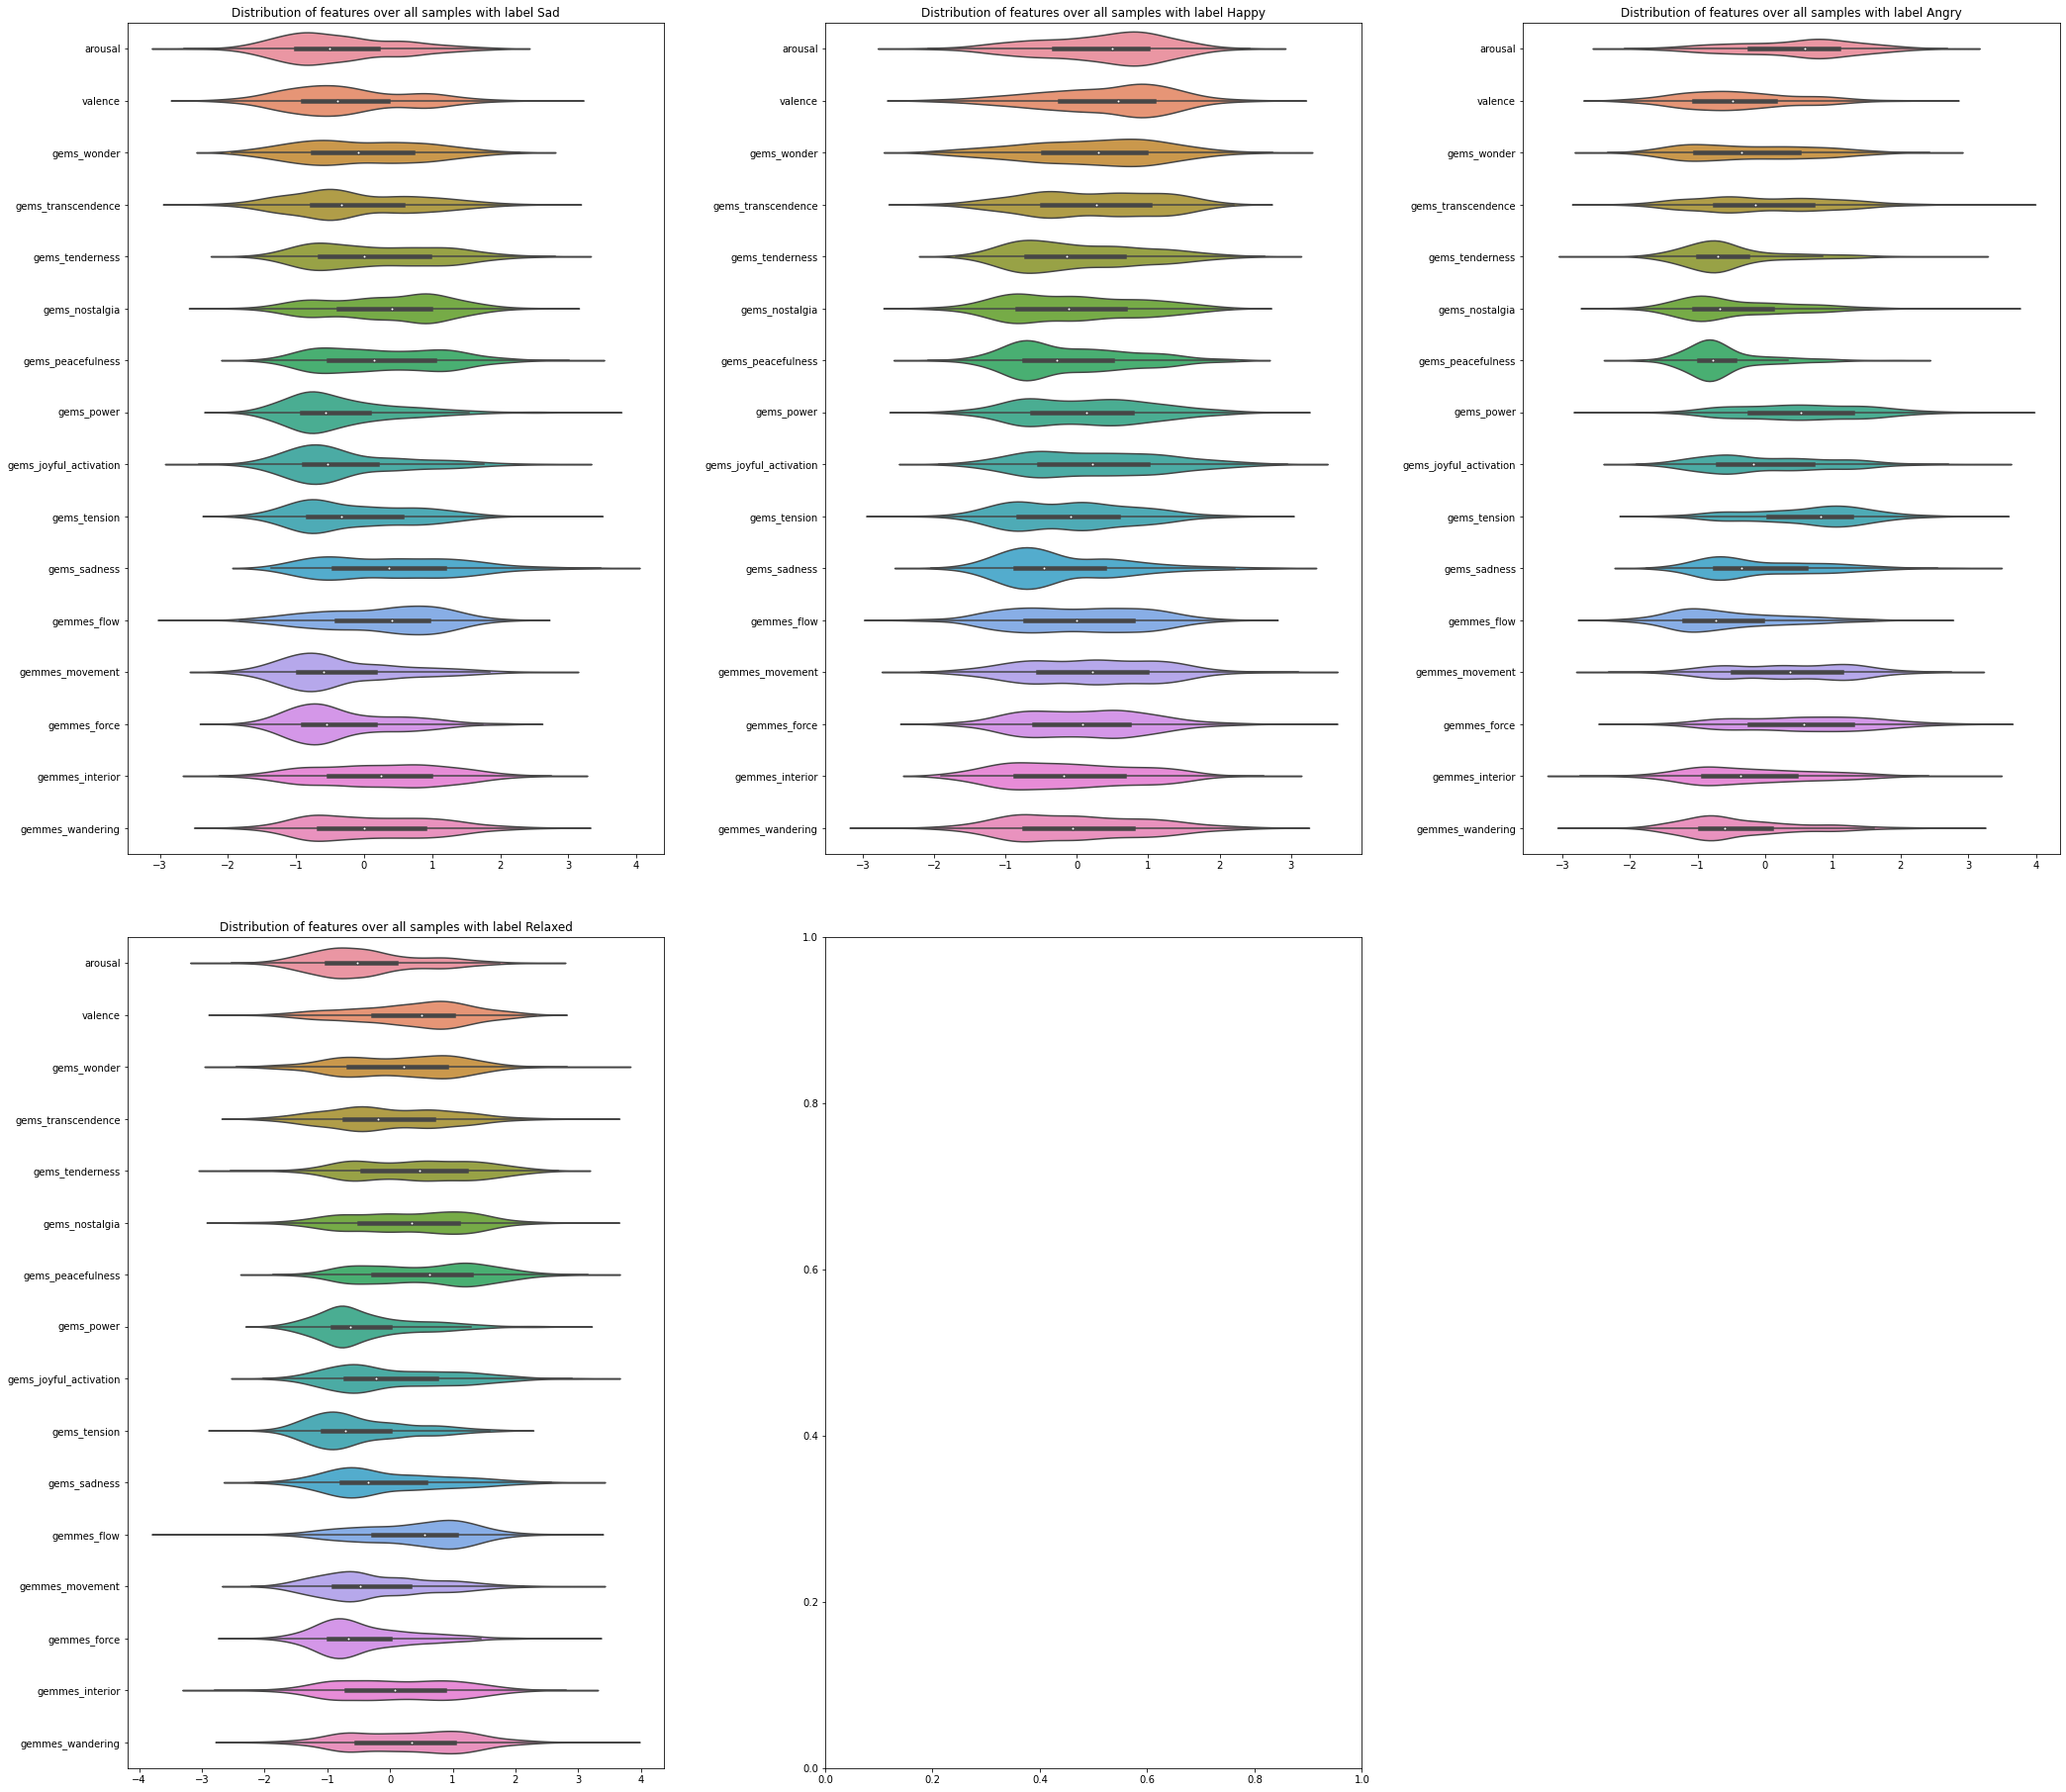

In [81]:
fig, axs = plt.subplots(2, 3, figsize=(35, 25))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.1, wspace=0.3)
axs[1, 2].remove()
for i, label in enumerate(list(anot["label"].unique())):
    row = 0 if i < 3 else 1
    col = i % 3
    filtered_df = anot[anot["label"] == label]
    label_feature_df = filtered_df.loc[:, feature_cols]
    axs[row, col].set_title(f"Distribution of features over all samples with label {label}")
    sns.violinplot(data=label_feature_df, orient='h', ax=axs[row, col])

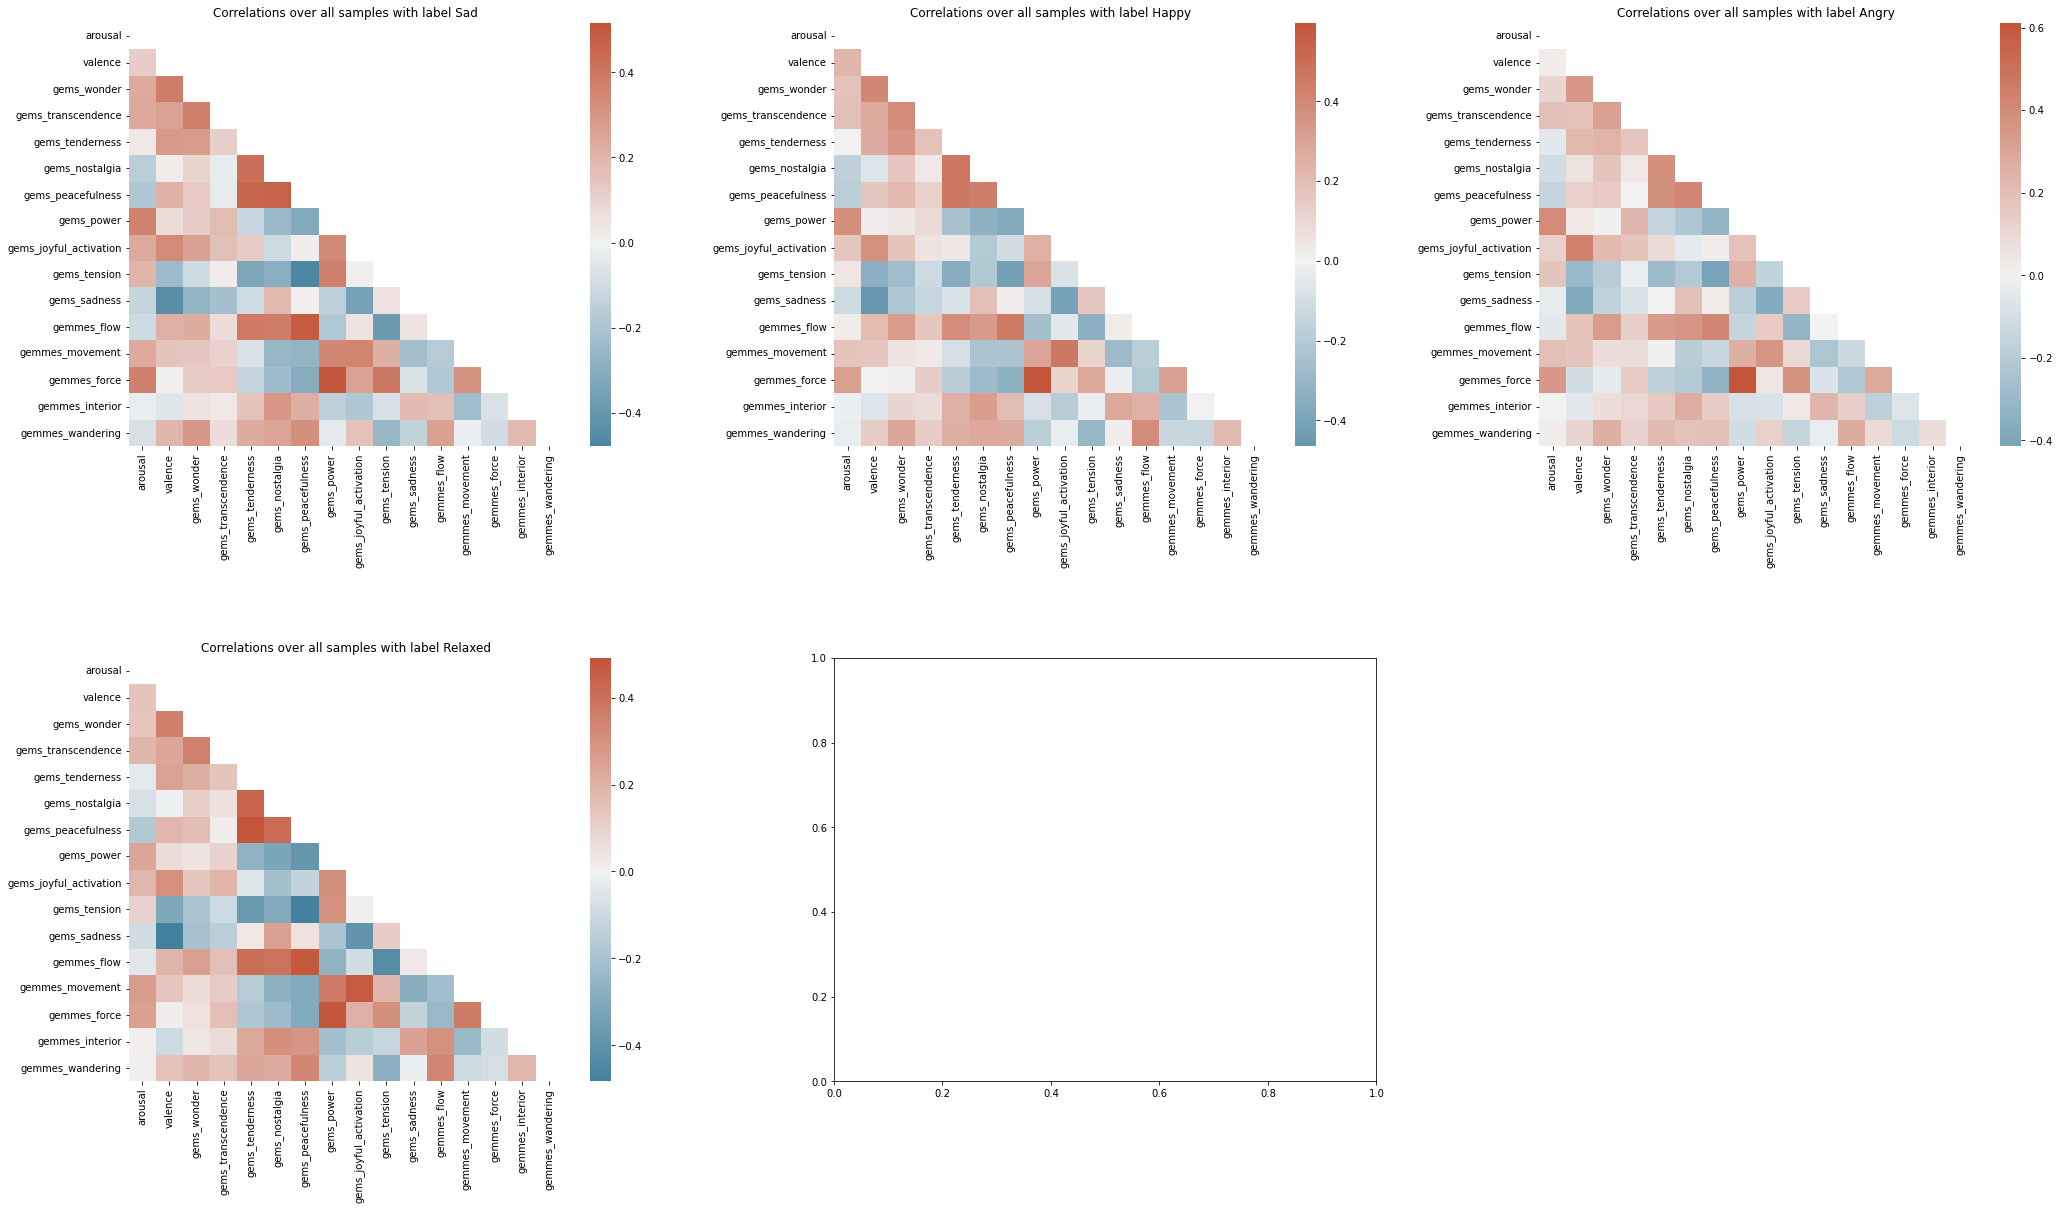

In [82]:
fig, axs = plt.subplots(2, 3, figsize=(35, 15))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.3)
axs[1, 2].remove()
for i, label in enumerate(list(anot["label"].unique())):
    row = 0 if i < 3 else 1
    col = i % 3
    filtered_df = anot[anot["label"] == label]
    label_feature_df = filtered_df.loc[:, feature_cols]
    corr_df = label_feature_df.corr()
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    axs[row, col].set_title(f"Correlations over all samples with label {label}")
    sns.heatmap(corr_df, mask=mask, cmap=cmap, center=0, ax=axs[row, col])

In [103]:
def max_label(df: pd.DataFrame) -> pd.DataFrame: 
    df = df.copy()
    
    f_df = df[feature_cols[2:11]]
    df = df.assign(label_gems = f_df.idxmax(axis=1))
    f_df = df[feature_cols[11:]]
    df = df.assign(label_gemmes = f_df.idxmax(axis=1))
    
    return df

def show_plot(df: pd.DataFrame, category: str):
    
    selection = alt.selection_multi(fields=[f'{category}'])
    color = alt.condition(selection,alt.Color(f'{category}:N', legend=None),alt.value('lightgray'))
    opacity = alt.condition(selection, alt.value(0.7), alt.value(0))
    
    scatter = alt.Chart(df).mark_circle(size=60).encode(
        x='valence:Q',
        y='arousal:Q',
        color=color,
        opacity=opacity,
        # tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
    ).interactive()
    
    legend = alt.Chart(df).mark_point().encode(
    y=alt.Y(f'{category}:N', axis=alt.Axis(orient='right')),
    color=color
    ).add_selection(selection)
    
    return scatter | legend

show_plot(df= max_label(anot), category= "label_gems")

alt.HConcatChart(...)

In [102]:
show_plot(df= max_label(anot), category= "label_gemmes")

alt.HConcatChart(...)

In [ ]:
# aggregate 